# Simulation Overview

### Description

Simulation of a M/M/C+M Erlang-A queueing model, which is a Markovian queueing model that allows for customer abandonment. Plots the error-minimizing weights for a convex combination LES and average wait times as well as correlation for future and past information. Run all cells to initialize the simulation, then input data into the user interface.

### Input 

_nValues_ := A list of the number of servers in the system. A simulation will be run for each input in the list.

_Number of Simulations_ := The number of simulated customers that move through the queuing system.

_Abandonment Mean_ := Mean of the random exponential distribution that determines abandonment. A greater mean results in fewer customers that abandon the queue.

_Standard Dev_ := Standard deviation from the mean of the exponential distribution used to determine interarrival times between customers.

_LESlag_ := The max number of customers to look "forward" or "backward" when computing LES. Used for future information analysis.

_Correlation Plot_ := If checked, plots LES vs wait time correlation for all integer lags in [-LESLag, LESLag].

_LES Alpha Plots_ := If checked, plots mean-square error and absolute error as a function of alpha, which is the weight on LES for a convex combination of LES and average weight time.

In [30]:
%matplotlib inline
import numpy as np  
import statistics as S
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
from sklearn.metrics import mean_squared_error

interactive(children=(Text(value='25, 100, 200', description='nValues'), Output()), _dom_classes=('widget-inte…

Accordion(children=(interactive(children=(IntSlider(value=0, description='n', max=1000000, step=5000), Output(…

Button(description='Run', style=ButtonStyle())

C:\Users\awiku\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


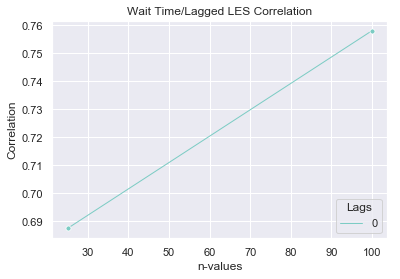

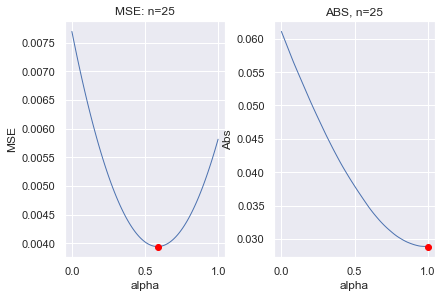

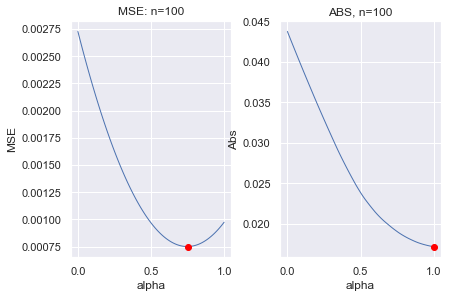

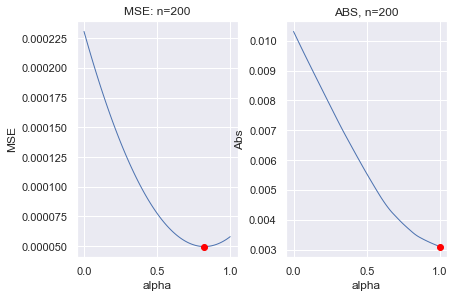

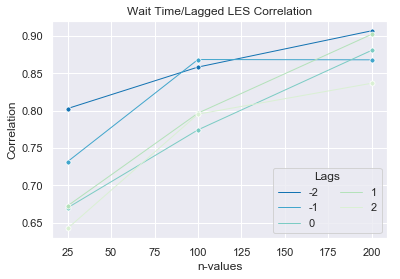

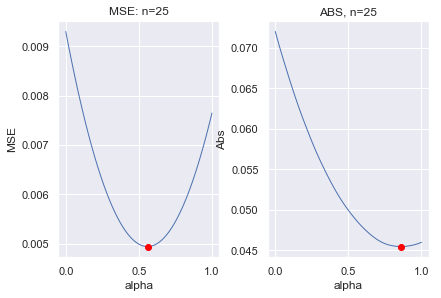

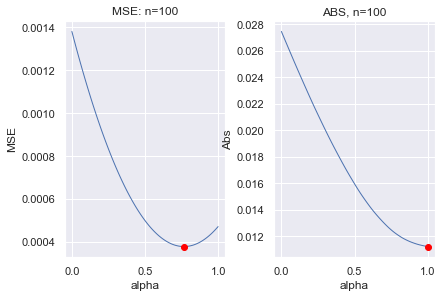

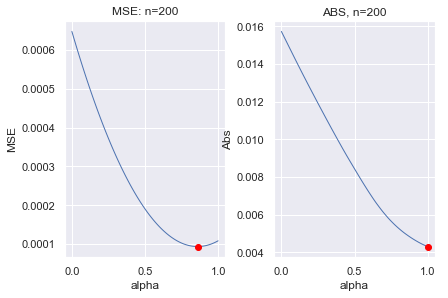

In [28]:
from IPython.display import display
from ipywidgets import HBox, widgets, Layout, Label, interactive
from IPython.display import clear_output


def sims(n):
    return n
numSimSlider = interactive(sims, n=widgets.IntSlider(value = 0, min = 0, max = 1000000, step = 5000), 
                           continuous_update=False)
def theta(Θ):
    return Θ
thetaSlider = interactive(theta, Θ=widgets.FloatSlider(value = 0.5, min = 0.5, max = 2, step = 0.5), 
                           continuous_update=False)
def beta(β):
    return β
betaSlider = interactive(beta, β=widgets.IntSlider(value = 0, min = -3, max = 3, step = 1), continuous_update=False)

def lags(Lag):
    return Lag
lagSlider = interactive(lags, Lag=widgets.IntSlider(value = 0, min = 0, max = 5, step = 1), continuous_update=False)

def nValues(nValues):
    return nValues
nValueList = interactive(nValues, nValues = widgets.Text(value="25, 100, 200"))
display(nValueList)

def corr(Correlation_Plot):
    return Correlation_Plot
corrPlot = interactive(corr, Correlation_Plot = True)
def error(LES_Alpha_Plots):
    return LES_Alpha_Plots
errorPlot = interactive(error, LES_Alpha_Plots = True)

display(HBox([corrPlot, errorPlot]))


        
accordion = widgets.Accordion(children=[numSimSlider, thetaSlider, betaSlider, lagSlider])
accordion.set_title(0, 'Number of Simulations')
accordion.set_title(1, 'Abandonment Mean')
accordion.set_title(2, 'Standard Dev')
accordion.set_title(3, 'LES Lag')
display(accordion)

start = widgets.Button(description="Run")
display(start)

def on_button_clicked(b):
    numSims = numSimSlider.result
    thetaValue = thetaSlider.result
    betaValue = betaSlider.result
    nValues = [int(e) for e in nValueList.result.split(',')]
    lags = lagSlider.result
    CorrPlot = corrPlot.result
    AlphaPlot = errorPlot.result
    if (CorrPlot): 
        correlationPlotter(nValues, betaValue, numSims, thetaValue, lag_int_to_list(lags))
    if (AlphaPlot):
        for i in nValues:
            interArrival = np.random.exponential(1/(i + betaValue*math.sqrt(i)), numSims)
            serviceTimes = np.random.exponential(1, numSims)
            abandonTimes = np.random.exponential(thetaValue, numSims)
            timeTuple = queueSim([0,10000000], interArrival, serviceTimes, abandonTimes, i)
            getdata(*timeTuple,i,betaValue,thetaValue,1)

    
start.on_click(on_button_clicked)

In [5]:
class customer:
    def __init__(self, arrival, service, patience, time, adjServ):
        self.interArrivalTime = arrival
        self.service_time = service
        self.patience_threshold = patience
        self.absolute_time = time

In [6]:
class serviceStation:
    def __init__(self, c , t):
        self.customer = c
        self.timeRemaining = t

In [7]:
def queueSim (t, ar, s, ab, N):

    # Initialize N empty service stations
    serviceList = []
    for i in range(0,N):
        serviceList.append(0)
    
    # A list (to be filled with customers) that represents the queue
    queueList = []
    queueList.append(customer(ar[0], s[0], ab[0], ar[0], s[0]))

    
    # A list of computed wait times for each customer
    W = []
    
    # A list of LES wait times for each customer
    LES = []
    LES.append(0)

    
    # A list containing the absolute times at which each customer arrives
    N = []
    N.append(ar[0])
    
    LESindices = []
 
    
    # Dummy indices
    i = 1
    LESindex = -1
    
    # Flag variable for ending the simulation
    end = False 
    
    
    for z in t:
        while (N[i-1] < z):
            
            # Update service timers
            serviceList = [x - ar[i] for x in serviceList]
            temp = all(y>0 for y in serviceList)

            # Store the absolute arrival time for the entering customer
            N.append(ar[i] + N[i-1])
            
     

            # Update the state of the queue
            while (temp==False and len(queueList) != 0):
                index_min = serviceList.index(min(serviceList))
                W.append(abs(round(N[i] - queueList[0].absolute_time + serviceList[index_min], 10)))
                serviceList[index_min] = serviceList[index_min] + queueList[0].service_time
                LESindex = LESindex + 1
                queueList.pop(0)
                temp = all(y>0 for y in serviceList)
            serviceList = [max(0, y) for y in serviceList] 
            LESindices.append(LESindex)
            
            

            # Construct the entering customer and place them in the queue
            queueList.append(customer(ar[i], s[i], ab[i], N[i], s[i]))
         
            
            # Remove any customers that renege prior to the entering customer's arrival time
            for a in queueList:
                if N[i] - a.absolute_time >= a.patience_threshold:
                    a.service_time = 0

                    
            
            # Incremement the system
            i = i + 1
            
            # Simulation exits if it reaches the end of the input data
            if i == len(ar) :
                end = True;
                break;
        if end:
            break;
    
     # Update service timers
    serviceList = [x - 10000000 for x in serviceList]
    temp = all(y>0 for y in serviceList)
            

    N.append(10000000 + N[i-1])
                   
    while (temp==False and len(queueList) != 0):
                index_min = serviceList.index(min(serviceList))
                W.append(abs(round(N[i] - queueList[0].absolute_time + serviceList[index_min], 10)))
                serviceList[index_min] = serviceList[index_min] + queueList[0].service_time
                queueList.pop(0)
                temp = all(y>0 for y in serviceList)


    for i in LESindices:
        LES.append(W[i])

    return W, LES


In [8]:
def lag_int_to_list(lag):
    lagList = []
    for i in range(-lag,lag+1):
        lagList.append(i)

    return lagList

In [9]:
def lesShift(Wait, LES, k):
    if (k<0):
        for i in range(0,-k):
            LES.pop(0)
            Wait.pop()
    else:
        for i in range(0,k):
            LES.pop()
            Wait.pop(0)
        

    return Wait, LES

In [10]:
def correlation(wTime, lesTime):
    return np.corrcoef(wTime, lesTime)[0][1]

In [11]:
def correlationPlotter (nValues, betaValue, numSims, thetaValue, lags):
    df = pd.DataFrame(index = nValues, columns = lags)
    correlations = []
    percFin = 0
    for k in lags:
        correlations.clear()
        for i in nValues:
            interArrival = np.random.exponential(1/(i + betaValue*math.sqrt(i)), numSims)
            serviceTimes = np.random.exponential(1, numSims)
            abandonTimes = np.random.exponential(thetaValue, numSims)
            timeTuple = queueSim([0,10000000], interArrival, serviceTimes, abandonTimes, i)
            shiftedTimeTuple = lesShift(*timeTuple, k)
            correlations.append(correlation(*shiftedTimeTuple))
        df[k] = correlations
    #colors = ['#00008B','#0000CD','#4169E1','#6495ED','#87CEEB','#000000','#FFC0CB','#FA8072','#FF0000','#CD5C5C','#8B0000']

    sns.set(rc={"lines.linewidth": 1})

    #Plot
    ax = sns.lineplot(hue="event", dashes=False, data=df, palette="GnBu_r",marker="o",markersize=5)
    ax.set_xlabel("n-values")
    ax.set_ylabel("Correlation")
    plt.title("Wait Time/Lagged LES Correlation")
    plt.legend(title = "Lags", ncol=2, loc='lower right');
    plt.show()

In [27]:
def getdata (LES, Wait, nV, betaValue, thetaValue, gammaValue):
    gamma = gammaValue;
    alphalist = np.arange(0,1.01,0.01)
    MSE = []
    Abs = []
    
    avg = sum(Wait)/len(Wait)
    #median = np.median(Wait)
    
    for alpha in np.arange (0,1.01,0.01):
        i = 0
        Ralphas = []
        Ralphas.clear()
        Rkmse = []
        Rkmse.clear()
        Rkabs = []
        Rkabs.clear()

        for x in LES:
            Ralpha = (alpha*x + (1-alpha)*avg)
            Ralphas.append(Ralpha)
            #Ralpha = (alpha*x + (1-alpha)*median)
            Rkmse.append( (Ralpha - Wait[i])**2 )
            Rkabs.append(max(Ralpha - Wait[i],0) + gamma*max(Wait[i] - Ralpha,0))
            i = i+1
        MSE.append(sum(Rkmse)/len(Rkmse))
        Abs.append(sum(Rkabs)/len(Rkabs))

    fig, (ax1, ax2) = plt.subplots(ncols=2)
    plt.tight_layout()
    ymin1 = min(MSE)
    mark1 = alphalist[MSE.index(ymin1)]
    ax1.plot(alphalist, MSE)
    ax1.plot(mark1, ymin1, color='red', marker='o') 
    ax1.set_ylabel('MSE')
    ax1.set_xlabel('alpha')
    ax1.set_title('MSE: n=' + str(nV))

    ymin2 = min(Abs)
    mark2 = alphalist[Abs.index(ymin2)]
    ax2.plot(alphalist, Abs)
    ax2.plot(mark2, ymin2, color='red', marker='o')
    ax2.set_ylabel('Abs')
    ax2.set_xlabel('alpha')
    ax2.set_title('ABS, n=' + str(nV))
    plt.show()